Importing required packages

In [0]:
!pip install scikit-learn
!pip install 'nltk==3.4.5'

In [0]:
import re
from sklearn.model_selection import train_test_split

In [0]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from tensorflow.keras import layers
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow.keras.callbacks import EarlyStopping

Dataset Import

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = "drive/My Drive/Colab Dataset/IMDB-Dataset.csv"
IMDBFull = pd.read_csv(path)

Data Preprocessing

In [0]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [0]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [0]:
X = []
sentences = list(IMDBFull['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [0]:
y = IMDBFull['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

Data split

In [0]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [0]:
X_train,X_val,y_train,Y_val=train_test_split(X_train,y_train,test_size=0.375)

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val=tokenizer.texts_to_sequences(X_val)
vocab_size = len(tokenizer.word_index) + 1

In [0]:
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)

Getting the Glove embedding file directly from the URL

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-05-09 15:03:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-05-09 15:03:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-05-09 15:03:14--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [0]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
!ls
!pwd

drive		   glove.6B.200d.txt  glove.6B.50d.txt	glove.6B.zip.1
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip	sample_data
/content


Indexing the Glove vectors

In [0]:
embeddings_index = {}
Glove = open('glove.6B.100d.txt', encoding='utf-8')
for line in Glove:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coeff
Glove.close()

In [0]:
embed_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embed_vector = embeddings_index.get(word)
    if embed_vector is not None:
        embed_matrix[index] = embed_vector

Defining early stopping to avoid extra training if overfitting, using just the embedding Layer.

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
embedding_length = 100
model = Sequential()
model.add(Embedding(vocab_size, embedding_length, input_length=max_words, weights=[embed_matrix], trainable=False))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 100)          7593800   
_________________________________________________________________
flatten_3 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 50001     
Total params: 7,643,801
Trainable params: 50,001
Non-trainable params: 7,593,800
_________________________________________________________________
None


In [0]:
history = model.fit(X_train, y_train, validation_data=(X_val, Y_val), epochs=5, batch_size=64, callbacks=[es])

Train on 25000 samples, validate on 15000 samples
Epoch 1/5
25000/25000 [==============================] - 4s 144us/step - loss: 0.6207 - accuracy: 0.6821 - val_loss: 0.5578 - val_accuracy: 0.7315
Epoch 2/5
25000/25000 [==============================] - 3s 138us/step - loss: 0.3940 - accuracy: 0.8212 - val_loss: 0.5735 - val_accuracy: 0.7379
Epoch 3/5
25000/25000 [==============================] - 3s 137us/step - loss: 0.3130 - accuracy: 0.8677 - val_loss: 0.5802 - val_accuracy: 0.7411
Epoch 00003: early stopping


In [0]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

10000/10000 [==============================] - 1s 75us/step
Test Loss: 0.5847090036392212
Test Accuracy: 0.7444000244140625


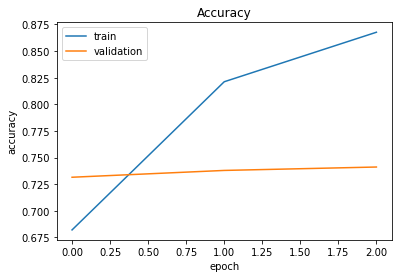

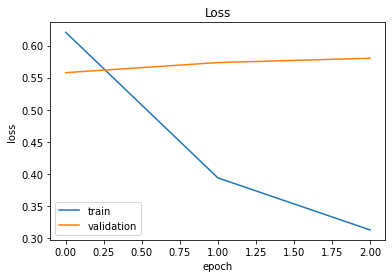

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='lower left')
plt.show()